# Image-to-Curve Model Training

This notebook takes the work done in the in the Image-to-Point model training notebook and trains a convolutional neural network (CNN) to generate a curve as wheel angle in real dimensional space. The network architecture will follow the [DAVE-2](https://developer.nvidia.com/blog/deep-learning-self-driving-cars/) as previously done by NVIDIA with the exceptions of the last couple of network layers and train using the [DeepPicar-v2](https://github.com/mbechtel2/DeepPicar-v2) dataset and the same model car. The first thing to do is to build the CNN.

## Model Building

Since this project is not being made into an overall package, what will be done is simply copy the relavent cells from the the first CNN in Tensorflow V2 as this notebook trains a similiar CNN. The difference is that this network uses a special loss function located in the author's [EECS Masters thesis repo](https://github.com/p678m854/EECS-Masters/). This loss function allows training a Bezier curve using discrite points in the loss 

In [1]:
from cv2 import cv2                                    # an open computer vision module
import glob                                            # Regix searching of files
import imageio                                         # loading images in numpy array
import matplotlib.pyplot as plt                        # Plotting
%matplotlib notebook
import numpy as np                                     # Array/Tensors
import os                                              # finding paths
import random                                          # For shuffling a video list
from scipy.special import comb                         # Grab combination for curve output
import sys                                             # manipulating the path variable
import tensorflow as tf                                # Neural Networks
from thesis.modules.loss_functions import bezier_loss  # Loss function of interest

In [2]:
# For debugging the autograph
# os.environ['AUTOGRAPH_VERBOSITY'] = '10'

In [3]:
# Image input specifications
input_img_height = 66
input_img_width = 200
input_img_channels = 3

# Curve specification
bezier_degree = 3

def create_curvy_dave(input_shape):
    # Create tensorflow object
    dave_2_model = tf.keras.Sequential()

    # First is a normalization layer in DAVE-2 but I don't see it in DeepPicar-v2 model-5conv_3fc
    # Attempting to normalize over color
    dave_2_model.add(tf.keras.layers.LayerNormalization(
        axis=[1, 2, 3], trainable=False,
        input_shape=input_shape  # Specify ahead of time for compilation
    ))

    # Second portion is the sequential 5x5 convolutions of increasing filters at 2x2 strides
    for i in range(3):
        dave_2_model.add(tf.keras.layers.Conv2D(
            filters=(24 + i*12),
            kernel_size=(5,5),
            strides=(2,2),
            padding='valid',
            data_format='channels_last',
            activation=tf.nn.relu
        ))

    # Third there is another grouping of Conv2D layers but a 3x3 kernel with no stride
    for i in range(2):
        dave_2_model.add(tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            padding='valid',
            data_format='channels_last',
            activation=tf.nn.relu
        ))

    # Fourth part is a flattening and then reduction to a single output
    dave_2_model.add(tf.keras.layers.Flatten())
    for n_neurons in [100, 50, (bezier_degree + 1)]:
        dave_2_model.add(tf.keras.layers.Dense(
            units=n_neurons,
            activation=(tf.nn.relu if n_neurons > 10 else tf.nn.tanh)
        ))
        
    # Fifth part reshapes the flat layer into a 2nd order tensor
    dave_2_model.add(tf.keras.layers.Reshape((bezier_degree + 1, 1)))

    # Compiling the model to see the initial structure
    dave_2_model.compile(
        optimizer='adam',
        loss=bezier_loss
    )
    
    return dave_2_model

dave_2_model = create_curvy_dave((input_img_height, input_img_width, input_img_channels))
dave_2_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 66, 200, 3)        79200     
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 2

## Model Training

The original dataset had only discrete angles for steering, namely the steering angle $\theta \in\lbrace -30,\ 0,\ 30 \rbrace$ but we wish for a continuous controller so a central moving average will be applied to the edge padding. The total dataset spans 11 videos of 11,000 frames but 1,000 frames is already pushing my laptop memory limits. The current plan to tackle this issue is to queue a video to go through, get the estimated continuous controls, and then batch train a video. As for wether to loop through all videos before any potential repeats or simply randomly train, it isn't clear a priori which is better. For now simply iterating it easiest to at least get a simple model. Setting the training:

In [4]:
# Grab video file list
dpv2_video_files = glob.glob("../data/external/DeepPicar-v2-data/*.avi")
# random.shuffle(dpv2_video_files)  # Shuffle to randomize for train-test split
"""
For recreatability, the image-to-point model was trained on these in order:

../data/external/DeepPicar-v2-data\out-video-2.avi
../data/external/DeepPicar-v2-data\out-video-9.avi
../data/external/DeepPicar-v2-data\out-video-7.avi
../data/external/DeepPicar-v2-data\out-video-8.avi
../data/external/DeepPicar-v2-data\out-video-10.avi
../data/external/DeepPicar-v2-data\out-video-1.avi
../data/external/DeepPicar-v2-data\out-video-11.avi
../data/external/DeepPicar-v2-data\out-video-6.avi
../data/external/DeepPicar-v2-data\out-video-4.avi

And tested on these in order
../data/external/DeepPicar-v2-data\\out-video-3.avi
../data/external/DeepPicar-v2-data\\out-video-5.avi

This model will do the same
"""
temp = []# For recreatability []
for i in [1, 8, 6, 7, 9, 0, 10, 5, 3, 2, 4]:
    temp = temp + [dpv2_video_files[i],]
dpv2_video_files = temp

# Some constants for analyzing videos from DeepPicar-v2
N_FRAMES = 1000  # All avi files in DeepPicar-v2 are 1,000 frames
ORIG_IMG_HEIGHT = 240
ORIG_IMG_WIDTH = 320
N_VIDEOS = len(dpv2_video_files)


# Define some helper functions
def key_from_video_filename(vf : str):
    directory_seperated = vf.split('\\')  # running on Windows
    fileno = int(directory_seperated[-1].split('-')[-1].split('.')[0])
    key_filename = 'out-key-%i.csv' % fileno
    return '\\'.join(directory_seperated[:-1] + [key_filename,])

In [5]:
# Filter setup
f_size = 5
f_array = np.ones((f_size,))/f_size
n_pad = int(np.ceil(f_size/2))

# Training Constants
EPOCHS = 50
VAL_SPLIT = 0.2
BATCH_SIZE = 256  # Want it to be a power of 4
N_IMAGES_PER_TRAINING_SEGMENT = 200
N_TRAIN_VIDEOS = 9  # 9/11  for train-val and 2/11 for testing
N_IMAGE_AUGS = 2  # Just flipping for now
N_LOOPS_THROUGH_VIDEOS = 4  # Looks like 4-5 is sufficient

"""
Bezier specifications:

DeepPicar-v2 has the time stamps of frames nominally 50 <strike>microseconds</strike> milliseconds 
which corresponds to 20 kHz. The output key says micro seconds but clearly the camer is not operating
at 20 kHz. The DeepPicar-v2 paper had the 30 Hz update rate on controller so attempting to do 2 Hz update rate
but the t parameter parameter window will be [0, 0.5] seconds scaled to [0, 1]

"""
dt_nom = 5e-2
t_window = 0.5  # seconds
n_pts = int(t_window/dt_nom)

# Output scaling
y_sf = np.pi/4  # 45 degrees, to allow better curves

In [6]:
# Sperate to avoid changing a parameter and then restarting from scratch
training_history = None

In [7]:
# Rerunning this cell will append to training.
# Additional epochs: EPOCHS*(N_FRAMES/N_IMAGES_PER_TRAINING_SEGMENT)*N_TRAIN_VIDEOS*N_LOOPS_THROUGH_VIDEOS

assert N_FRAMES % N_IMAGES_PER_TRAINING_SEGMENT == 0, "Need even division of video frames over training"
# Loop over videos
for i in range(N_LOOPS_THROUGH_VIDEOS):
    print(f"Loop {i}:")
    # Iterate through the videos for training
    for vf in dpv2_video_files[:N_TRAIN_VIDEOS]:
        print(f"\t{vf}")
        
        # Load in csv of correct outputs
        y_video = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=2  # Angle is in the third column
        )/y_sf
        t_video = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=0  # time is in the first column
        )*(10**-6)  # microseconds to seconds
        t_video = t_video - t_video[0]  # de bias the time vector

        # Pad, filter, and then reduce
        temp = np.pad(y_video, pad_width=n_pad, mode='edge')
        del y_video
        y_video = np.convolve(temp, f_array, mode='same')[n_pad:-n_pad]
        del temp

        # Get video capture going
        video_capture = cv2.VideoCapture(vf)

        # Iterate through video training batches
        n_sessions = N_FRAMES // N_IMAGES_PER_TRAINING_SEGMENT
        for j in range(n_sessions):
            # Determine number images in session
            if j == (n_sessions - 1):
                n_images = N_FRAMES - j*N_IMAGES_PER_TRAINING_SEGMENT - n_pts
            else:
                n_images = N_IMAGES_PER_TRAINING_SEGMENT
            
            # Allocate training tensors
            x_train = np.empty(
                (N_IMAGE_AUGS*n_images, input_img_height, input_img_width, 3)
            )
            y_train = np.empty((N_IMAGE_AUGS*n_images, n_pts, 2))  # n training examples of n_pts pairs of (time, y)

            # Preallocate load tensor
            x_load = np.empty((n_images, ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))
            
            
            # Load in the N_IMAGES_PER_TRAINING_SEGMENT
            for k in range(n_images):
                _, image = video_capture.read()
                x_load[k] = image
                
                # Get corresponding outputs
                y_train[k,:,0] = (t_video[
                    (j*N_IMAGES_PER_TRAINING_SEGMENT + k):(j*N_IMAGES_PER_TRAINING_SEGMENT + k + n_pts)
                ] - t_video[j*N_IMAGES_PER_TRAINING_SEGMENT + k])/t_window
                y_train[k,:,1] = y_video[
                    (j*N_IMAGES_PER_TRAINING_SEGMENT + k):(j*N_IMAGES_PER_TRAINING_SEGMENT + k + n_pts)
                ]
                
                del image

            # Reshape from AVI to DAVE-2
            x_train[:n_images] = tf.image.resize(
                images=tf.convert_to_tensor(x_load),
                size=[input_img_height, input_img_width]
            ).numpy()

            # Image Augmentation and output correspondance
            # Horizontal flip:
            x_train[n_images:] = x_train[:n_images,:,::-1,:]
            y_train[n_images:,:,0] = y_train[:n_images,:,0]  # Time marks still the same
            y_train[n_images:,:,1] = -y_train[:n_images,:,1]  # Flip poles though

            # Train the model
            session_hist = dave_2_model.fit(
                x=x_train, y=y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=0,  # 1,
                validation_split=VAL_SPLIT,
            )

            # Append in training history
            sess_hist = np.stack((
                    np.array(session_hist.history['loss']),
                    np.array(session_hist.history['val_loss'])
                ), axis=0).T

            if training_history is None:
                training_history = sess_hist
            else:
                temp = np.concatenate((training_history, sess_hist), axis=0)
                del training_history
                training_history = temp
                del temp
            del sess_hist

        # Some resource freeing
        video_capture.release()

        # Free up memory
        del x_train, y_train, x_load, y_video, video_capture
    

Loop 0:
	../data/external/DeepPicar-v2-data\out-video-10.avi


C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


	../data/external/DeepPicar-v2-data\out-video-7.avi
	../data/external/DeepPicar-v2-data\out-video-5.avi
	../data/external/DeepPicar-v2-data\out-video-6.avi
	../data/external/DeepPicar-v2-data\out-video-8.avi
	../data/external/DeepPicar-v2-data\out-video-1.avi
	../data/external/DeepPicar-v2-data\out-video-9.avi
	../data/external/DeepPicar-v2-data\out-video-4.avi
	../data/external/DeepPicar-v2-data\out-video-2.avi
Loop 1:
	../data/external/DeepPicar-v2-data\out-video-10.avi
	../data/external/DeepPicar-v2-data\out-video-7.avi
	../data/external/DeepPicar-v2-data\out-video-5.avi
	../data/external/DeepPicar-v2-data\out-video-6.avi
	../data/external/DeepPicar-v2-data\out-video-8.avi
	../data/external/DeepPicar-v2-data\out-video-1.avi
	../data/external/DeepPicar-v2-data\out-video-9.avi
	../data/external/DeepPicar-v2-data\out-video-4.avi
	../data/external/DeepPicar-v2-data\out-video-2.avi
Loop 2:
	../data/external/DeepPicar-v2-data\out-video-10.avi
	../data/external/DeepPicar-v2-data\out-video-

In [8]:
dave_2_model.save_weights(
    filepath="../models/temporary/cnn-image-to-curve.h5"
)
np.save("../reports/training-history/temp/ccn-i2c-th.npy", training_history)

## Model Verification

This portion will check both the training history to demonstrate progress as well as find the accuracy of a classifier and MSE loss function on the test videos to show models validity.

### Training History

The overall training history of the model:

<IPython.core.display.Javascript object>


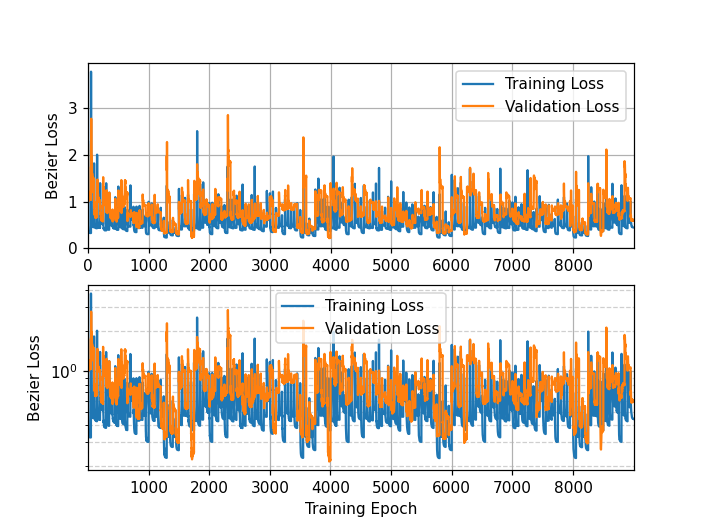

In [9]:
epoch_vec = np.arange(training_history.shape[0])

fig, ax = plt.subplots(2, 1)

ax[0].plot(epoch_vec, training_history[:, 0], color='C0', label="Training Loss")
ax[0].plot(epoch_vec, training_history[:, 1], color='C1', label="Validation Loss")

ax[0].set_xlim(left=0, right=epoch_vec[-1])
ax[0].set_ylim(bottom=0)

# ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Bezier Loss")

ax[0].legend()

ax[0].grid(True, which='major',  linestyle='-')
ax[0].grid(True, which='minor',  linestyle='--', alpha=0.6)

ax[1].plot(epoch_vec[1:], training_history[1:, 0], color='C0', label="Training Loss")
ax[1].plot(epoch_vec[1:], training_history[1:, 1], color='C1', label="Validation Loss")

ax[1].set_xlim(left=1, right=epoch_vec[-1])
ax[1].set_yscale('log')

ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Bezier Loss")

ax[1].legend()

ax[1].grid(True, which='major',  linestyle='-')
ax[1].grid(True, which='minor',  linestyle='--', alpha=0.6)

# Put in dashed and solid lines to indicate new data shifts


plt.show()

The above training history shows some improvement over time, roughly a half decade over the four loops albeit it is hard to tell. From previous versions of this notebook, there was a large divergence to where the model was only predicting straight lines after about 7 loops through 9 videos so another couple of loops might help the current model.

### Model accuracy

Going from continuous to discrete again, now trying to show the accuracy of the model if simply turning at 30$^\circ$ or going straight. This is to give a more direct comparison with DeepPicar-v2. The way it will work is that all frames within sequential time frames will be predicted using the curves. At the start of each time frame, the model will take the frame and then predict the time evolving wheel angle curve by Bezier curve poles. Each frame is time stamp so we can plot a "real-time" wheel angle on the video frame.

In [21]:
# Some preallocations
N_TEST_VIDEOS = N_VIDEOS - N_TRAIN_VIDEOS

y_pred = np.empty((N_FRAMES*N_TEST_VIDEOS,))
y_act = np.empty((N_FRAMES*N_TEST_VIDEOS,))

def bezier_output(t, points):
    """Returns Bezier curve value at t given points"""
    d = len(points) - 1
    ans = np.zeros(points.shape[1:])
    
    for i, p in enumerate(points):
        ans += comb(d, i)*(t**i)*((1-t)**(d-i))*p
    
    return ans

#### Image-to-Point

In [22]:
# Millisecond window
t_window_ms = int(t_window*1e3)

# Iterate through the videos
for i, vf in enumerate(dpv2_video_files[N_TRAIN_VIDEOS:]):
    # Set an initial time for window
    t0 = 0
    
    # Read in actual steering angle
    y_act[i*N_FRAMES:(i+1)*N_FRAMES] = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=2  # Angle is in the third column
        )/np.pi*6  # Convert (-pi/6, pi/6) to (-1, 1)
    
    # Get the frame times
    t_video = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=0  # Angle is in the third column
        )
    
    # Preallocate load tensor, only look at one image at a time
    image_tensor = np.empty((1, ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))

    # Get video capture going
    video_capture = cv2.VideoCapture(vf)
    
    # Iterate through video by training batches since we know that works
    for j in range(N_FRAMES):

        # Grab the image
        _, image = video_capture.read()
        image_tensor[0] = image
        del image
        
        # Always update
        # Get new prediction
        curve_points = dave_2_model.predict(
            x=tf.image.resize(
                images=tf.convert_to_tensor(image_tensor),
                size=[input_img_height, input_img_width]
            ).numpy(),
            verbose=0
        )[0,:,:]/np.pi*6  # radians to (-1, 1)

        # update window base
        t0 = t_video[j]
        
        # Calculate bezier parameter
        t = (t_video[j] - t0)/t_window_ms
        
        # Preform prediction
        y_pred[i*N_FRAMES + j] = bezier_output(t, curve_points)[0]
    
    # Some resource freeing
    video_capture.release()
    del image_tensor

In [23]:
# Do rounding to ensure -1, 0, 1
y_pred = np.round(y_pred).astype('int')
y_act = np.round(y_act).astype('int')

y_pred[y_pred < -1] = -1
y_pred[y_pred > 1] = 1

In [24]:
cross_correlation_matrix = np.zeros((3,3))  # correlation matrix to see matches
for i in range(3):
    for j in range(3):
        cross_correlation_matrix[i, j] = np.count_nonzero(np.logical_and(
            np.equal(y_act, i-1),
            np.equal(y_pred, j-1),
        ))
        
"""
Quick note:
* column is predicted angle from -30 to 30 in left to right.
* row is actual from -30 to 30 from top to bottom.
"""
print(cross_correlation_matrix)

# Printing out the model statistics of discrete controller in the augmented domain
n_total = y_pred.shape[0]
n_correct = np.trace(cross_correlation_matrix)
n_incorrect = n_total - n_correct
print("Model accuracy: %2.2f%%'" % (100*n_correct/n_total))

[[ 60. 111.   9.]
 [ 48. 667. 261.]
 [ 13. 223. 608.]]
Model accuracy: 66.75%'


#### Image-to-Curve

In [11]:
# Millisecond window
t_window_ms = int(t_window*1e3)

# Iterate through the videos
for i, vf in enumerate(dpv2_video_files[N_TRAIN_VIDEOS:]):
    # Set an initial time for window
    t0 = 0
    
    # Read in actual steering angle
    y_act[i*N_FRAMES:(i+1)*N_FRAMES] = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=2  # Angle is in the third column
        )/np.pi*6  # Convert (-pi/6, pi/6) to (-1, 1)
    
    # Get the frame times
    t_video = np.loadtxt(
            fname=key_from_video_filename(vf),
            delimiter=',',
            skiprows=1,  # ignore the column titles
            usecols=0  # Angle is in the third column
        )
    
    # Preallocate load tensor, only look at one image at a time
    image_tensor = np.empty((1, ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))

    # Get video capture going
    video_capture = cv2.VideoCapture(vf)
    
    # Iterate through video by training batches since we know that works
    for j in range(N_FRAMES):

        # Grab the image
        _, image = video_capture.read()
        image_tensor[0] = image
        del image
        
        # See if need to do new curve prediction
        if t_video[j] > (t0 + t_window_ms):
            # Get new prediction
            curve_points = dave_2_model.predict(
                x=tf.image.resize(
                    images=tf.convert_to_tensor(image_tensor),
                    size=[input_img_height, input_img_width]
                ).numpy(),
                verbose=0
            )[0,:,:]/np.pi*6  # radians to (-1, 1)
            
            # update window base
            t0 = t_video[j]
        
        # Calculate bezier parameter
        t = (t_video[j] - t0)/t_window_ms
        
        # Preform prediction
        y_pred[i*N_FRAMES + j] = bezier_output(t, curve_points)[0]
    
    # Some resource freeing
    video_capture.release()
    del image_tensor

In [12]:
# Do rounding to ensure -1, 0, 1
y_pred = np.round(y_pred).astype('int')
y_act = np.round(y_act).astype('int')

In [13]:
cross_correlation_matrix = np.zeros((3,3))  # correlation matrix to see matches
for i in range(3):
    for j in range(3):
        cross_correlation_matrix[i, j] = np.count_nonzero(np.logical_and(
            np.equal(y_act, i-1),
            np.equal(y_pred, j-1),
        ))
        
"""
Quick note:
* column is predicted angle from -30 to 30 in left to right.
* row is actual from -30 to 30 from top to bottom.
"""
print(cross_correlation_matrix)

# Printing out the model statistics of discrete controller in the augmented domain
n_total = y_pred.shape[0]
n_correct = np.trace(cross_correlation_matrix)
n_incorrect = n_total - n_correct
print("Model accuracy: %2.2f%%'" % (100*n_correct/n_total))

[[ 83.  46.  33.]
 [268. 343. 313.]
 [177. 268. 336.]]
Model accuracy: 38.10%'


A brief comment about the accuracy is that going straight will be correct ~50% of the time but while the accuracy is low, there seems to be a lot of boarder cases so we will check the quality by overlaying results on the videos. We will check two ways, one by using the CNN as a image-to-point predictor by simply taking the first bezier spline pole which is $p(0)$ and then by forcasting along the curve and only updating points at the boundary of time intervals.

### Image-to-Point Model

In [14]:
# Video constants
video_save_location = "../reports/video-quality-checks/image-to-point/"
AVI_WIDTH = 360
AVI_HEIGHT = 240


# Plotting constants
xbase = 180
ybase = 220
r = 120
r_text = r + 10
font = cv2.FONT_HERSHEY_SIMPLEX

# Iterate through the DeepPicar-v2 to make a video for quality analysis
for i, vf in enumerate(dpv2_video_files): 
    
    # Load in csv of correct outputs
    angle_video = np.loadtxt(
        fname=key_from_video_filename(vf),
        delimiter=',',
        skiprows=1,  # ignore the column titles
        usecols=2  # Angle is in the third column
    )
    
    # Save file name and reader ready
    vf_name = vf.split('\\')[-1]
    writer = None
    
    # Set up reading video
    cap = cv2.VideoCapture(vf)
    current_frame = 0
    
    # Read all the video
    while cap.isOpened():
        if current_frame < N_FRAMES:
            # Read in a frame from the video
            ret, frame = cap.read()

            # A quit option
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Initialize writer if necessary
            if writer is None:
                fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                output_path = video_save_location + vf_name
                writer = cv2.VideoWriter(
                    output_path,
                    fourcc,  # color code
                    30,  # FPS
                    (frame.shape[1], frame.shape[0]),  # Image Shape
                    True  # in color
                )
                
            # Have the model predict the value
            theta = dave_2_model.predict(
                x=tf.image.resize(
                    images=tf.convert_to_tensor(frame.reshape((1,  ORIG_IMG_HEIGHT, ORIG_IMG_WIDTH, 3))),
                    size=[input_img_height, input_img_width]
                ).numpy(),
                verbose=0
            )[0,0]*y_sf  # Go from (-1, 1) to (-pi/6, pi/6)
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,)*3,
                5
            )
            frame = cv2.putText(
                frame,
                'P',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,)*3,
                cv2.LINE_AA
            )
            
            # Calculations for actual on frame
            theta = angle_video[current_frame]
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,) + (0,)*2,
                5
            )
            frame = cv2.putText(
                frame,
                'A',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,) + (0,)*2,
                cv2.LINE_AA
            )

            # Write out and increment
            writer.write(frame)
            current_frame += 1  # Increment a counter

            # Delete frame
            del frame
            
        else:
            writer.release()
            cap.release()
            cv2.destroyAllWindows()
            break

The videos look very smooth and this method seems to be a very good way to enforce smoothness between outputs with slightly different inputs.

### Image-to-Curve

In [15]:
# Video constants
video_save_location = "../reports/video-quality-checks/image-to-curve/"

# Iterate through the DeepPicar-v2 to make a video for quality analysis
for i, vf in enumerate(dpv2_video_files): 
    
    # start time of window
    t0 = 0
    
    # Load in csv of correct outputs and time stamps
    t_video = np.loadtxt(
        fname=key_from_video_filename(vf),
        delimiter=',',
        skiprows=1,  # ignore the column titles
        usecols=0  # Millisecond time in first column
    )
    angle_video = np.loadtxt(
        fname=key_from_video_filename(vf),
        delimiter=',',
        skiprows=1,  # ignore the column titles
        usecols=2  # Angle is in the third column
    )
    
    # Save file name and reader ready
    vf_name = vf.split('\\')[-1]
    writer = None
    
    # Set up reading video
    cap = cv2.VideoCapture(vf)
    current_frame = 0
    
    # Read all the video
    while cap.isOpened():
        if current_frame < N_FRAMES:
            # Read in a frame from the video
            _, frame = cap.read()

            # A quit option
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Initialize writer if necessary
            if writer is None:
                fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                output_path = video_save_location + vf_name
                writer = cv2.VideoWriter(
                    output_path,
                    fourcc,  # color code
                    30,  # FPS
                    (frame.shape[1], frame.shape[0]),  # Image Shape
                    True  # in color
                )
                
                
            # See if need to do new curve prediction
            if t_video[current_frame] > (t0 + t_window_ms):
                # Get new prediction
                curve_points = dave_2_model.predict(
                    x=tf.image.resize(
                        images=tf.convert_to_tensor(frame.reshape((1,) + frame.shape)),
                        size=[input_img_height, input_img_width]
                    ).numpy(),
                    verbose=0
                )[0,:,:]*y_sf

                # update window base
                t0 = t_video[current_frame]
        
            # Calculate bezier parameter
            t = (t_video[current_frame] - t0)/t_window_ms
            
            # Have the model predict the value
            theta = bezier_output(t, curve_points)[0]
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,)*3,
                5
            )
            frame = cv2.putText(
                frame,
                'P',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,)*3,
                cv2.LINE_AA
            )
            
            # Calculations for actual on frame
            theta = angle_video[current_frame]
            
            dx = int(r*np.sin(theta))
            dy = int(-r*np.cos(theta))
            dx_t = int(r_text*np.sin(theta))
            dy_t = int(-r_text*np.cos(theta))
            
            # Plot prediction on the frame
            frame = cv2.line(
                frame,
                (xbase, ybase),
                (xbase + dx, ybase + dy),
                (255,) + (0,)*2,
                5
            )
            frame = cv2.putText(
                frame,
                'A',
                (xbase + dx_t, ybase + dy_t),
                font,
                2,
                (255,) + (0,)*2,
                cv2.LINE_AA
            )

            # Write out and increment
            writer.write(frame)
            current_frame += 1  # Increment a counter

            # Delete frame
            del frame
            
        else:
            writer.release()
            cap.release()
            cv2.destroyAllWindows()
            break

## Conclusion

While it does not appear the outputs are dense enough to allow for image-to-curve applications, the usage of image-to-point with the Bezier Curve training does dramatically improve the results.